In [10]:
import numpy as np

from filterpy.monte_carlo import residual_resample

import cv2

from PIL import Image

import matplotlib.pyplot as plt

In [2]:
class ParticleFilter():
    def __init__(self, fitness, transition, nfeatures=5,nparticles=100, distribution=None, mu = None, sigma = None, lb = None, ub = None):
        self.fitness = fitness
        self.transition = transition
        self.nfeatures = nfeatures
        self.nparticles = nparticles
        self.distribution = distribution
        self.mu = mu
        self.sigma = sigma
        self.lb = lb
        self.ub = ub
        self.initialize_particles()
    

    def initialize_particles(self):
        self.particles = []
        if(self.distribution):
            for i in range(self.nfeatures):
                if(self.distribution[i] == 'normal'):
                    self.particles.append(np.random.normal(size=(self.nparticles, 1), loc = self.mu[i], scale=self.sigma[i]))
                else:
                    self.particles.append(np.random.uniform(low = self.lb[i], high = self.ub[i], size=(self.nparticles, 1)))
        else:
            self.particles = np.random.normal(size=(self.nparticles, self.nfeatures))
        self.particles = np.array(self.particles).reshape(4,2000)
        self.particles = np.swapaxes(self.particles, 0, 1)
        print(self.particles.shape)
        #if(self.sigma): 
        #    self.particles *= self.sigma
        #if(self.mu):
        #    self.particles += self.mu
        if(self.lb):
            self.particles = np.clip(self.particles, self.lb, np.inf)
        if(self.ub):
            self.particles = np.clip(self.particles, -np.inf, self.ub)
        self.weights = np.zeros(shape=(self.nparticles))

    
    def return_particles(self):
        return self.particles
    def return_mean(self):
        idx = np.argpartition(self.weights, int(self.nparticles * 0.8))
        
        return np.average(self.particles[idx[int(self.nparticles * 0.8):]], weights = self.weights[idx[int(self.nparticles * 0.8):]], axis = 0)

    def predict(self, u):
        self.particles = self.transition(self.particles, u)



    def update(self, observation):
        self.weights = self.fitness(self.particles, observation)
        self.weights += 1.e-20
        self.weights /= np.sum(self.weights)
    
    def resample(self):
        indexes = residual_resample(self.weights)
        self.particles = self.particles[indexes,:]
        self.weights = self.weights[indexes]

    


    def next_step(self, observation, u):
        self.predict(u)
        self.update(observation)
        self.resample()

        




In [3]:
def transition(particles, u):
    return particles + u + np.random.normal(scale = 0.2, size=particles.shape)


def fitness(particles, observation):
    return 1/(np.abs(particles[:,0] - observation)+1.e-100)

In [4]:
pf = ParticleFilter(transition = transition, fitness = fitness, nfeatures=1)

ValueError: cannot reshape array of size 100 into shape (4,2000)

In [5]:
pf.particles.shape

obs = 0

NameError: name 'pf' is not defined

In [6]:
obs = obs + 4.5
pf.next_step(obs, 4.5)
import matplotlib.pyplot as plt
%matplotlib inline
print(obs)
plt.plot(pf.particles, np.zeros(pf.particles.shape), '.')

NameError: name 'obs' is not defined

In [7]:
pf.return_mean()


#pf.weights.shape
#pf.particles.shape

NameError: name 'pf' is not defined

In [59]:
np.sum(np.array([[1,1],[1,2]]), axis=-1)

array([2, 3])

In [60]:
np.sin(np.array([1,2,3]))

array([0.84147098, 0.90929743, 0.14112001])

In [8]:
# considering a particle = [h, l, rw, rd]

def transition(particles, u):
    dx = u[0]
    dh = u[1]
    particles[:,0] = np.clip(particles[:,0] + dh + np.random.normal(loc=0.0, scale=0.01,size=particles[:,0].shape), - 30 * np.pi/180, 30 * np.pi/180)
    particles[:,1] = particles[:,1] + dx * np.sin(particles[:,0]) + np.random.normal(loc=0.0, scale=0.1,size=particles[:,1].shape)
    particles[:,2] = np.clip(particles[:,2] + np.random.normal(loc=0.0, scale=10,size=particles[:,2].shape), 0, np.inf)
    particles[:,3] = np.clip(particles[:,3] + np.random.normal(loc=0.0, scale=10,size=particles[:,3].shape), 0, np.inf)
    return particles


def create_masks(particles, observation):
    masks = []
    for particle in particles:
        aux = np.zeros(observation.shape)
        central_x = observation.shape[1]//2
        mean_l = central_x - particle[2]//2 + particle[1]
        mean_r = central_x + particle[2]//2 + particle[1]
        left_l = np.clip(mean_l - particle[3]//2, 0, observation.shape[1])
        right_l = np.clip(mean_l + particle[3]//2, 0, observation.shape[1])
        left_r = np.clip(mean_r - particle[3]//2, 0, observation.shape[1])
        right_r = np.clip(mean_r + particle[3]//2, 0, observation.shape[1])

        #print(left_l, right_l)
        aux[:,int(left_l):int(right_l)] = 1
        aux[:,int(left_r):int(right_r)] = 1

        aux = skew_image(aux, int(particle[0] * 9 * 180/np.pi))

        masks.append(aux)
    return np.array(masks)

def skew_image(image, value = 0):

    IMAGE_H = image.shape[0]
    IMAGE_W = image.shape[1]
    
    #aa = 250 + value
    #bb = 400 + value

    #src = np.float32([[200, IMAGE_H], [450, IMAGE_H], [0, 0], [IMAGE_W, 0]])
    #dst = np.float32([[aa, IMAGE_H], [bb, IMAGE_H], [0, 0], [IMAGE_W, 0]])


    aa = 50 + value
    bb = 150 + value

    src = np.float32([[40, IMAGE_H], [160, IMAGE_H], [0, 0], [IMAGE_W, 0]])
    dst = np.float32([[aa, IMAGE_H], [bb, IMAGE_H], [0, 0], [IMAGE_W, 0]])


    M = cv2.getPerspectiveTransform(src, dst) 
    Minv = cv2.getPerspectiveTransform(dst, src) 

    warped_img = cv2.warpPerspective(image, Minv, (IMAGE_W, IMAGE_H))
    
    return warped_img


def atenuation_factor(weights):
    idx = np.argpartition(weights, 20)
    weights[idx] *= 0.2
    return weights


def fitness(particles, observation):
    pred = create_masks(particles, observation)
    print(pred.shape)
    print(observation.shape)
    observation = observation[None, :]
    print(observation.shape)
    intersection = observation * pred
    notObservation = 1 - observation
    union = observation + (notObservation * pred)

    #print(intersection.shape)

    result = (np.sum(intersection, axis=(-1,-2)) + 1.e-100) / (np.sum(union, axis=(-1,-2)) + 1.e-100)

    #result = atenuation_factor(result)
    print(result.shape)
    return result


'''
def fitness(particles, observation):
    pred = create_masks(particles, observation)
    observation = observation[None,:]
    print(pred.shape)
    print(observation.shape)

    result = np.sum(pred*observation - 0.8*(1 - pred)*observation, axis=(-1,-2))
    print(result.shape)
    return result
'''

'\ndef fitness(particles, observation):\n    pred = create_masks(particles, observation)\n    observation = observation[None,:]\n    print(pred.shape)\n    print(observation.shape)\n\n    result = np.sum(pred*observation - 0.8*(1 - pred)*observation, axis=(-1,-2))\n    print(result.shape)\n    return result\n'

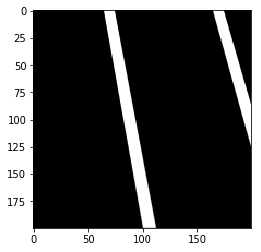

In [393]:
#transition(np.array([[0,0,0,0],[1,2,3,4]], dtype=np.float), [1,0])
640
plt.imshow(create_masks(np.array([[np.pi/180 * -4,20,100,10],[1,2,3,4]], dtype=np.float), np.zeros([200,200]))[0], cmap='gray')

In [16]:
fitness(np.array([[np.pi/180 * 1,-1,500,200],[1,2,3,4]], dtype=np.float), np.ones([480,640]))

(2, 480, 640)
(480, 640)
(1, 480, 640)
(2,)


array([0.37514056, 0.00395508])

In [17]:
pf = ParticleFilter(transition = transition, fitness = fitness, nfeatures=4, mu = [0,0,300,200], sigma = [1,10,200,200], lb = [-np.inf, -np.inf, 0, 0])

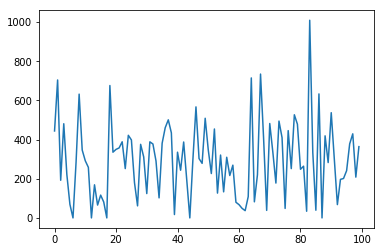

In [18]:
plt.plot([a[2] for a in pf.particles])

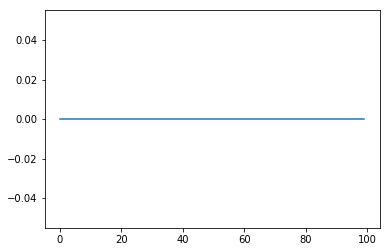

In [19]:
plt.plot([a for a in pf.weights])

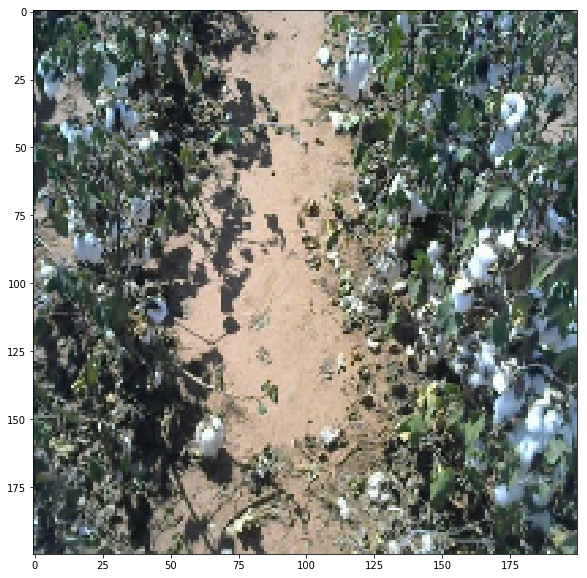

In [11]:
image = np.array(Image.open('nav_front/frame_70.jpg'))

image = cv2.resize(image,(200,200))

plt.figure(figsize=(20,10))
plt.imshow(image)

In [12]:
def exg(im_to_binarize):
    im_to_binarize = im_to_binarize.astype(np.float)
    R_ = im_to_binarize[:,:,2]/np.max(im_to_binarize[:,:,2])
    G_ = im_to_binarize[:,:,1]/np.max(im_to_binarize[:,:,1])
    B_ = im_to_binarize[:,:,0]/np.max(im_to_binarize[:,:,0])
    
    r = R_/(R_+G_+B_)
    g = G_/(R_+G_+B_)
    b = B_/(R_+G_+B_)
    
    excess_red = 1.4*r - g
    excess_green = 2*g - r - b
    return excess_green


def exg_th(img, th = [-0., 0.5]):
    a = exg(img)
    b = np.zeros(shape = a.shape)
    b[a<th[0]] = 0
    b[(a>=th[0]) & (a < th[1])] = (a[(a>=th[0]) & (a < th[1])] - th[0])/(th[1] - th[0])
    b[a >= th[1]] = 1
    return b

In [13]:
np.min(exg(image))

-0.22000000000000003

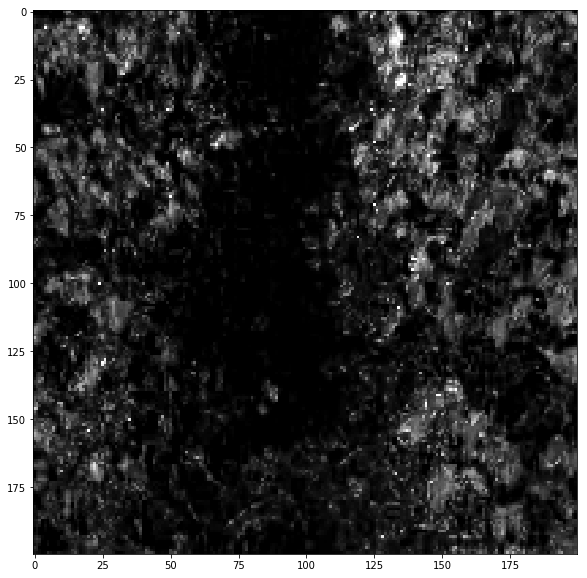

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(exg_th(image), cmap='gray')

mask_show = exg_th(image)

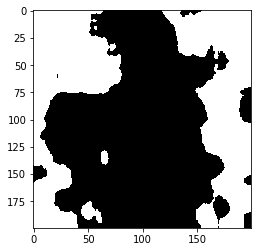

In [186]:
import imageProcess_ORIGINAL as imp


frame, I1_prime, I2_prime, I3_prime = imp.get_img(image)

cv_output, mask_show, centroid_1, mask_show2 = imp.get_centroid(frame, I1_prime, I2_prime, I3_prime)

mask_show = mask_show[:,:,0]

plt.imshow(mask_show, cmap='gray')



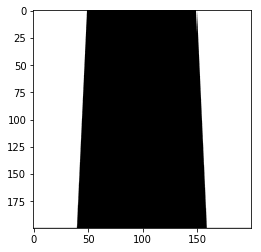

In [235]:
mask_show = np.zeros(mask_show.shape)
mask_show[:,int(0):int(50)] = 1
mask_show[:,int(150):] = 1

mask_show = skew_image(mask_show, value = 0)

plt.imshow(mask_show, cmap='gray')

In [17]:
pf = ParticleFilter(transition = transition, fitness = fitness, nfeatures=4, mu = [0,0,0,20], sigma = [1,10,5,5], lb = [-np.pi, -100, 0, 0], ub=[np.pi, 100, 500, 500], nparticles = 2000, distribution=['normal','normal','uniform','uniform'])

(2000, 4)


In [18]:
#mask_show.shape

pf.particles[500]

array([-2.55418901e-01, -6.34796308e+00,  2.88867402e+02,  1.60052919e+02])

In [19]:
pf.next_step(mask_show, [0,0])

print(np.max(pf.weights))

(2000, 200, 200)
(200, 200)
(1, 200, 200)
(2000,)
0.0009382351716516341


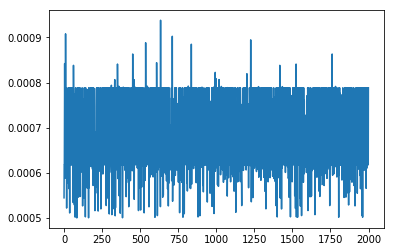

In [20]:
plt.plot([a for a in pf.weights])

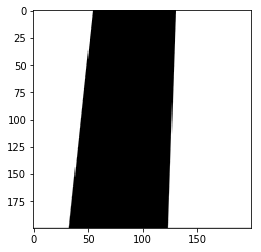

In [561]:
plt.imshow(create_masks([pf.return_mean()], mask_show)[0], cmap='gray')

#pf.particles.shape

#idx = np.argpartition(pf.weights, 800)

#print(pf.particles[idx[800:]]).shape


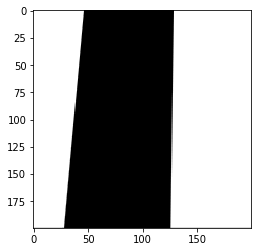

In [562]:
plt.imshow(create_masks(pf.particles, mask_show)[np.argmax(pf.weights)], cmap='gray')

In [66]:
pf.particles[np.argmax(pf.weights)]

array([-4.11585384e-02, -1.72787379e-01,  3.60321761e+02,  1.71925970e+02])